In [ ]:
from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data

import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [ ]:
(X, Y), (X_val, Y_val) = load_data('mnist', flatten=False)
map_size = (8, 8)
latent_dim = 10
input_shape = X.shape[1:]
autoencoder, encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, [32, 64, 64], 3, 2)
autoencoder.compile('adam', 'mse')
save_dir = 'results/tmp'
epochs = 1
batch_size = 256
save_file = Path(f'{save_dir}/ae_weights-epoch{epochs}.h5')
if save_file.is_file():
    autoencoder.load_weights(save_file)
else:
    autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
    # autoencoder.save_weights(save_file)
som_layer = SOMLayer(map_size, name='som')(encoder.output)
model = Model(
    inputs=autoencoder.input, outputs=[autoencoder.output, som_layer]
)
model.compile(
    loss={"decoder_0": "mse", "som": 'mse'},
    loss_weights=[1, 0.],
    optimizer='adam',
)

1/1 [==============================] - 0s 146ms/step


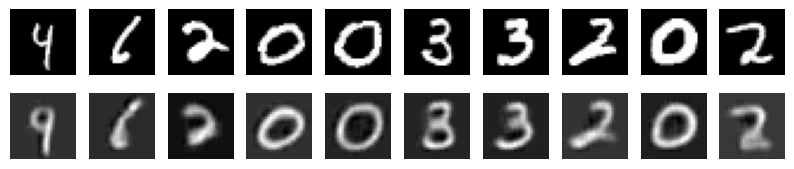

In [ ]:
indices = np.random.randint(len(X), size=10)
theseX = X[indices]
theseXp = autoencoder.predict(theseX)
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for x, xp, axs in zip(theseX, theseXp, axes.T):
    axs[0].imshow(x, cmap='gray')
    axs[1].imshow(xp, cmap='gray')
    for ax in axs:
        ax.axis('off')

1/1 [==============================] - 0s 98ms/step


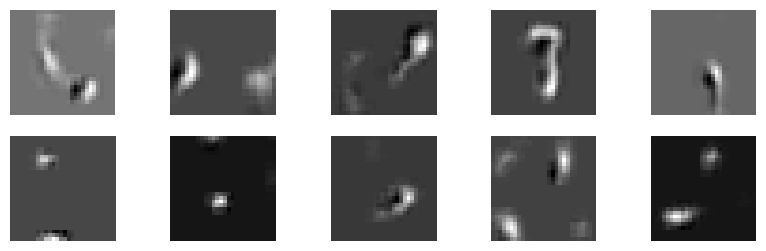

In [ ]:
images = decoder.predict(np.eye(10)[:, :, None])
fig, axes = plt.subplots(2, 5, figsize=(10, 3))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im.reshape((28, 28)), cmap='gray')
    ax.axis('off')

In [ ]:
epochs = 5
batch_size = 256
for layer in model.layers[:-1]:
    layer.trainable = False
model.fit(X, [X, Y], epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/5
274/274 [==============================] - 3s 10ms/step - loss: 0.0377 - decoder_0_loss: 0.0296 - som_loss: 27.2148
Epoch 2/5
274/274 [==============================] - 3s 10ms/step - loss: 0.0313 - decoder_0_loss: 0.0268 - som_loss: 27.3292
Epoch 3/5
274/274 [==============================] - 3s 10ms/step - loss: 0.0280 - decoder_0_loss: 0.0249 - som_loss: 27.4025
Epoch 4/5
274/274 [==============================] - 3s 10ms/step - loss: 0.0261 - decoder_0_loss: 0.0237 - som_loss: 27.4603
Epoch 5/5
274/274 [==============================] - 3s 10ms/step - loss: 0.0246 - decoder_0_loss: 0.0226 - som_loss: 27.5116


In [ ]:
model.get_layer(name='som').get_weights()[0].shape

(64, 10)

2/2 [==============================] - 0s 4ms/step


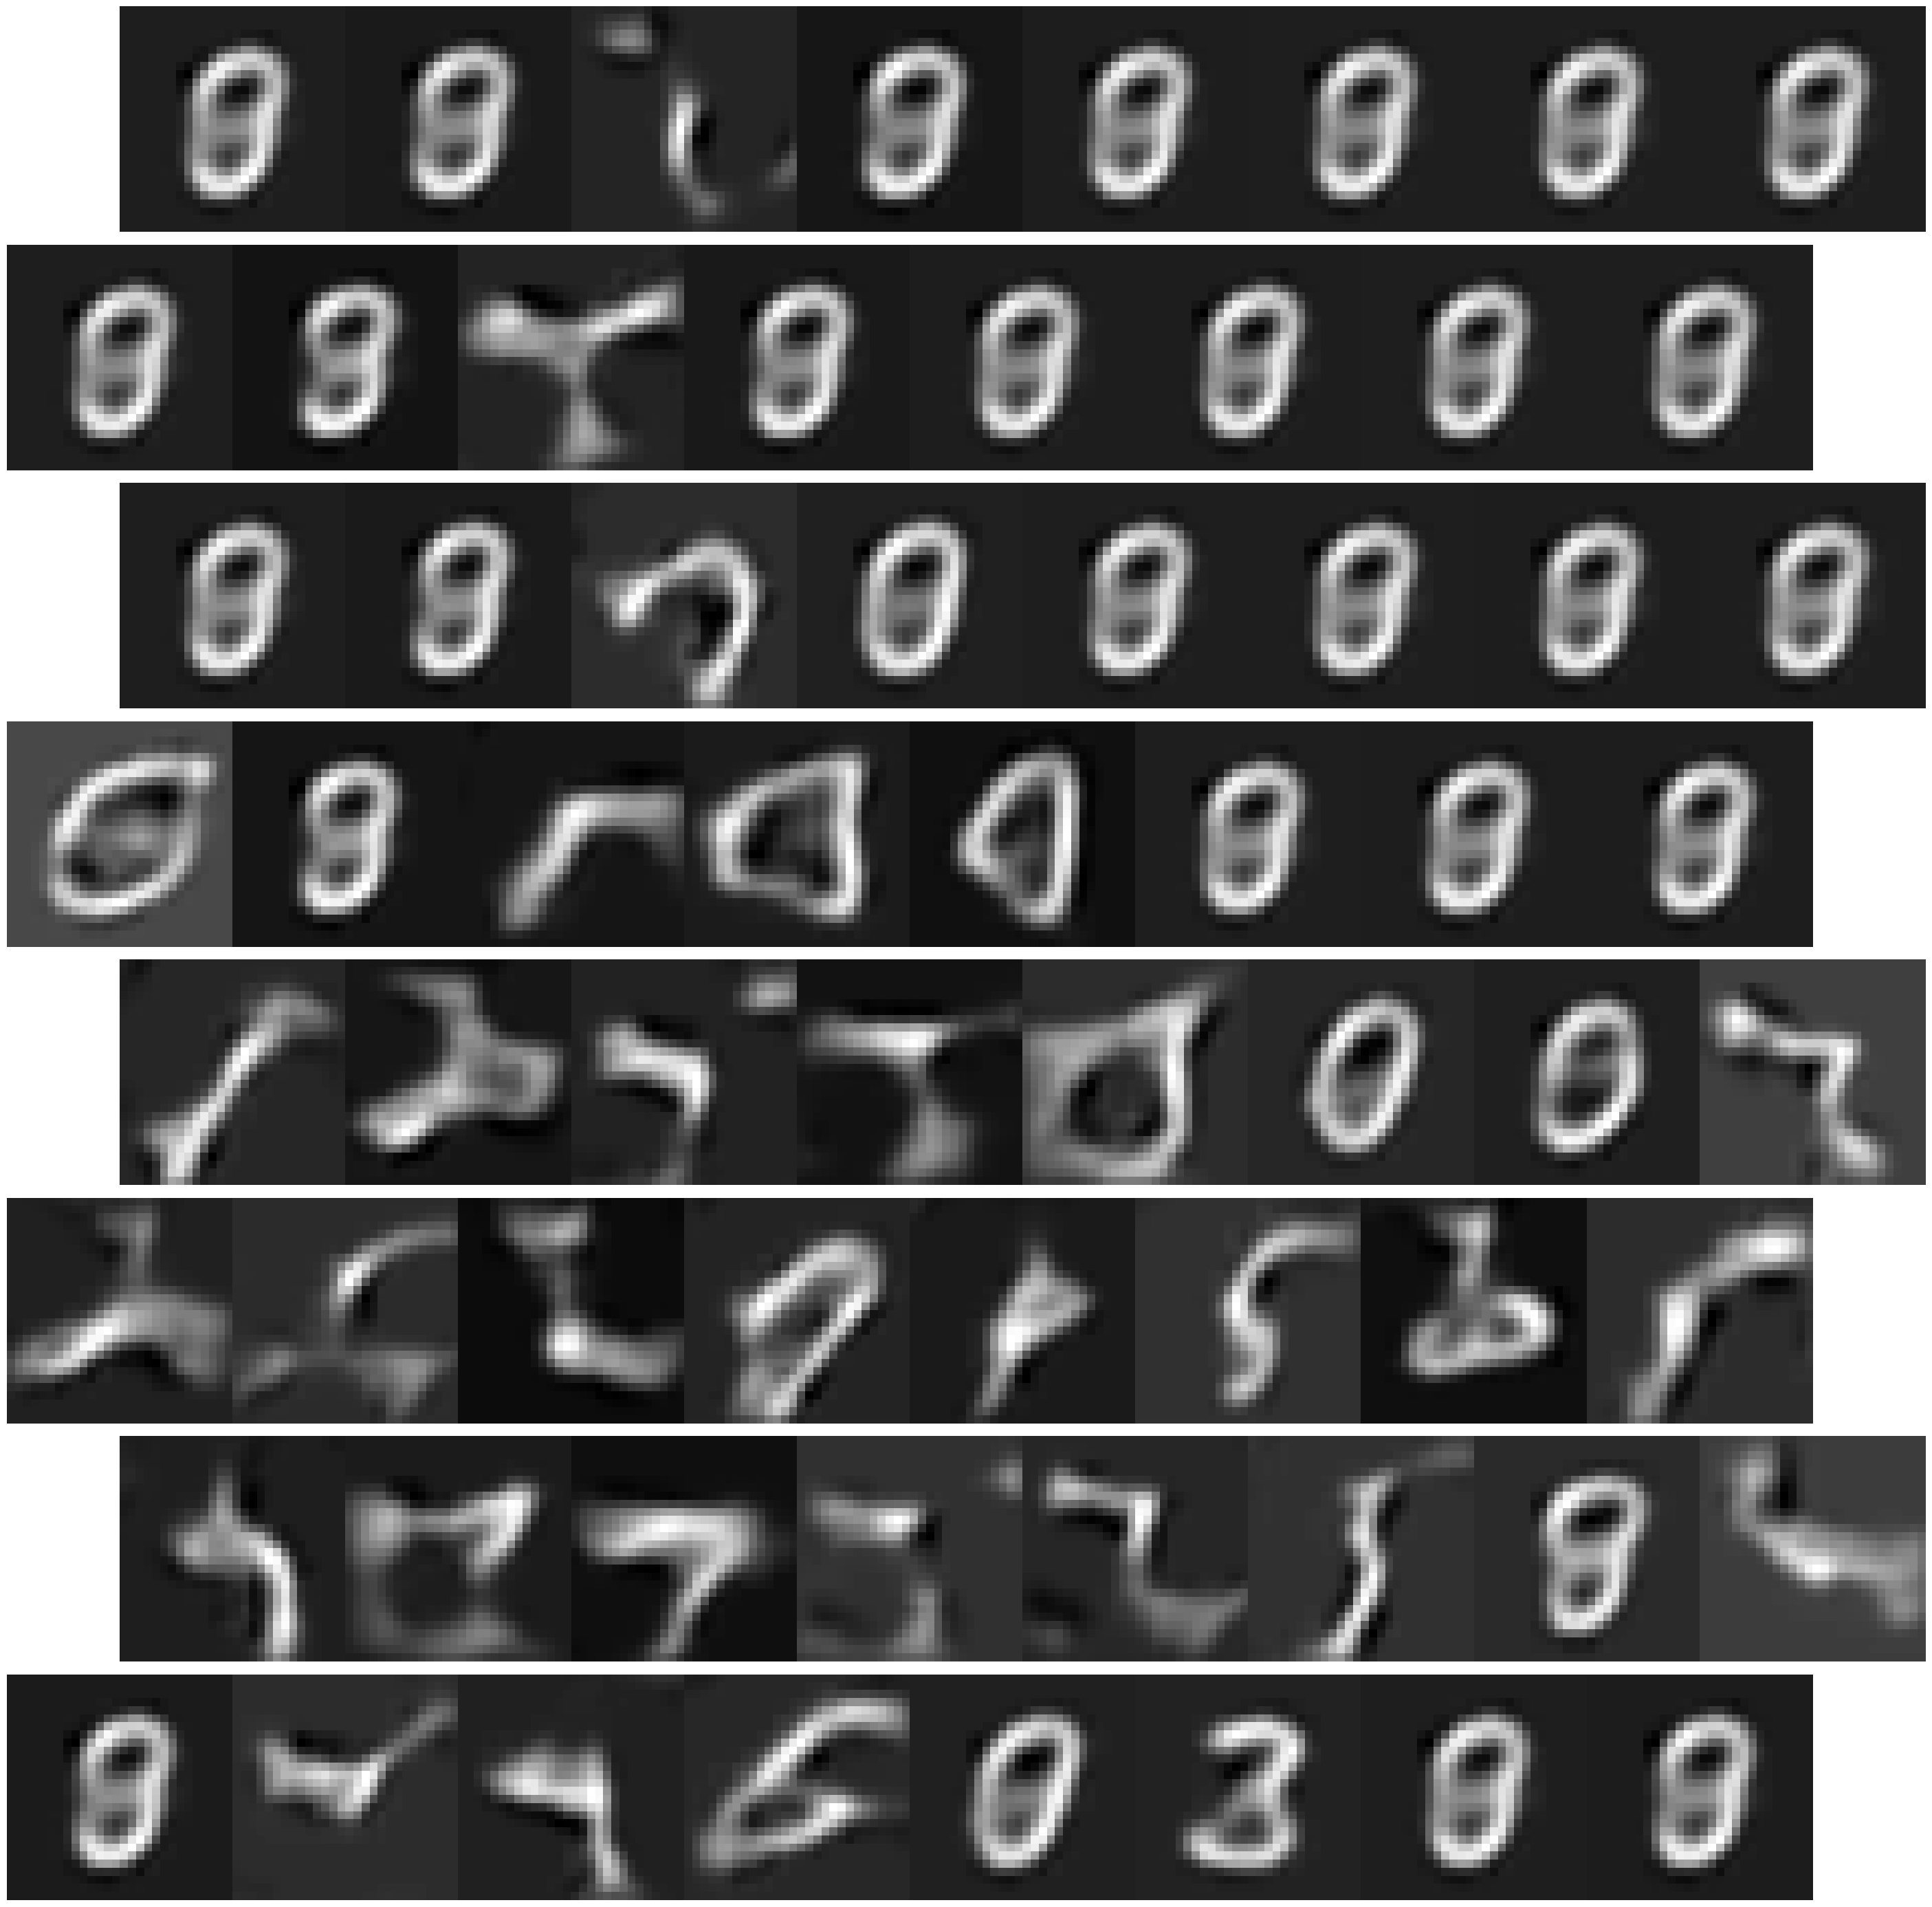

In [ ]:
images = decoder.predict(model.get_layer(name='som').get_weights()[0][:, :, None])
fig, axes = honeycomb_panel(*map_size, ratio=1)
# fig, axes = plt.subplots(*map_size, figsize=(15, 15))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [ ]:
from keras.layers import Lambda
argmax_layer = Lambda(lambda x: tf.argmin(x, axis=1), name='y_pred')(som_layer)
classifier = Model(inputs=encoder.input, outputs=argmax_layer)
classifier.predict(X[0:100])

4/4 [==============================] - 0s 2ms/step


array([49, 29, 29, 41, 53, 38, 41, 43, 46, 29, 30, 54,  5, 30, 39,  4, 49,
        4, 30, 41, 62, 29, 29, 41, 54,  5, 14,  5,  5, 53, 49, 33, 30,  4,
       29, 54,  6, 29, 49, 29, 41,  4, 53, 41, 49,  4, 54, 14, 49, 33, 30,
       30, 30, 46, 14,  4, 55,  4, 43, 41, 29, 53, 43, 30, 29, 54, 30, 41,
       32, 43, 49, 30, 41, 29, 33, 29,  5, 41, 29,  4, 30, 43, 43, 30,  5,
       14,  5,  4, 30,  4, 30, 30, 53, 29, 14, 43, 39, 14, 30, 41])

In [ ]:
from keras.layers import Input
def zeroloss(ypred, ytrue):
    return 0.
(X, Y), (X_val, Y_val) = load_data('mnist', flatten=True)
map_size = (8, 8)

x = Input(shape=(X.shape[1],), name='input')
som = SOMLayer(map_size, name='som')(x)
onlysom = Model(inputs=x, outputs=som)
onlysom.compile(optimizer='adam')
onlysom.fit(X, batch_size=256, epochs=5)

In [ ]:
images = onlysom.get_layer(name='som').get_weights()[0]

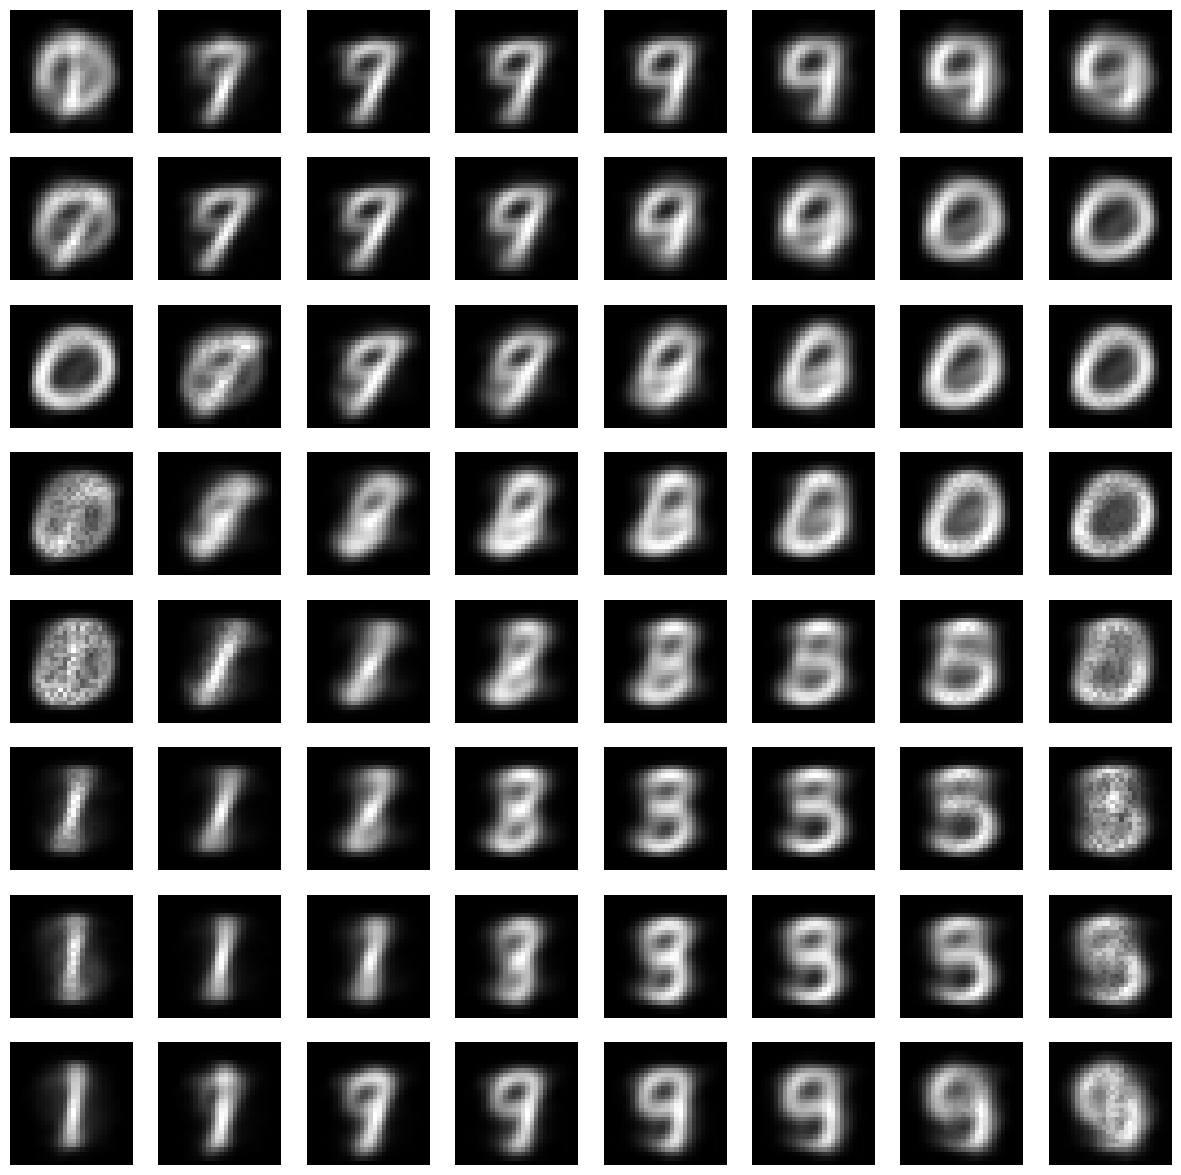

In [ ]:
fig, axes = plt.subplots(*map_size, figsize=(15, 15))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im.reshape((28, 28)), cmap='gray')
    ax.axis('off')